# text embeddings + conceptual axes

In [52]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F
import textwrap

import plotly.express as px
import plotly.graph_objects as go



In [53]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [151]:

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B')
model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')

model.eval()

Qwen3Model(
  (embed_tokens): Embedding(151669, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

In [146]:
axes_map = {'social_issues': ['justice', 'equality', 'rights', 'fairness', 'discrimination', 'prejudice', 'persecution', 'humanity', 'dignity', 'compassion', 'liberty', 'protection', 'civil rights', 'human rights', 'alien', 'person', 'power', 'unconstitutional'],
            'economics': ['economy', 'economic', 'labor', 'commerce', 'trade', 'industry', 'railway', 'development', 'profit', 'wages', 'capital', 'prosperity', 'cheap labor', 'economic necessity', 'business', 'license', 'tax', 'fee', 'revenue', 'labour', 'employment', 'wage', 'miner', 'mining', 'land', 'goods', 'property', 'economic', 'industry', 'regulate', 'forfeit', 'penalty', 'pay']}

In [159]:
df = pd.read_csv("../data/metadata.csv")

df.head()

,filename,author,type,text
0,regina_v_wing_chong.txt,Crease,case,"CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\..."
1,wong_hoy_woon_v_duncan.txt,Crease,case,"CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n..."
2,regina_v_mee_wah.txt,Begbie,case,BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...
3,regina_v_victoria.txt,Begbie,case,"OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT..."
4,quong_wing_v_the_king.txt,Fitzpatrick,case,QUONG WING v. THE KING. CAN. \r\n\r\nSupreme ...


In [148]:
crease_texts = df[df['author'] == 'Crease']['text'].tolist()
begbie_texts = df[df['author'] == 'Begbie']['text'].tolist()
other_texts = df[df['author'] =='Others']['text'].tolist() # the chinese regulation act -- much more racist

judge_dict = {
    'Crease': crease_texts,
    'Begbie': begbie_texts,
    'other': other_texts}

In [149]:
def get_token_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=32768, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    attention_mask = inputs['attention_mask']
    last_token_index = attention_mask.sum(dim=1) - 1
    
    batch_size = outputs.last_hidden_state.shape[0]
    last_token_index = last_token_index.unsqueeze(-1).expand(-1, outputs.last_hidden_state.shape[-1]).unsqueeze(1)
    last_token_embedding = torch.gather(outputs.last_hidden_state, 1, last_token_index).squeeze(1)

    return last_token_embedding.squeeze().cpu().numpy()

In [128]:
import numpy as np

def create_axis_vector(keywords, corpus_texts, model, tokenizer, get_embedding_for_text):
    context_sentences = []

    for doc in corpus_texts:
        sentences = [s.strip() for s in doc.split('.') if len(s.strip()) > 10]
        for sentence in sentences:
            if any(keyword in sentence.lower() for keyword in keywords):
                context_sentences.append(sentence)

    context_embeddings = [get_embedding_for_text(sent, model, tokenizer) for sent in context_sentences]
    axis_vector = np.mean(context_embeddings, axis=0)
    axis_vector_normalized = axis_vector / np.linalg.norm(axis_vector)
    
    return axis_vector_normalized

In [152]:
all_texts = df['text'].tolist()

contextual_social_axis = create_contextual_axis_vector(keywords=axes_map['social_issues'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )

contextual_economic_axis = create_contextual_axis_vector(keywords=axes_map['economics'],corpus_texts=all_texts,model=model,tokenizer=tokenizer,get_embedding_for_text=get_token_embedding )


Searching corpus for context sentences related to: justice, equality, rights, fairness, discrimination, prejudice, persecution, humanity, dignity, compassion, liberty, protection, civil rights, human rights, alien, person, power, unconstitutional...
Found 291 context sentences.
Generating embeddings for all context sentences...
Searching corpus for context sentences related to: economy, economic, labor, commerce, trade, industry, railway, development, profit, wages, capital, prosperity, cheap labor, economic necessity, business, license, tax, fee, revenue, labour, employment, wage, miner, mining, land, goods, property, economic, industry, regulate, forfeit, penalty, pay...
Found 459 context sentences.
Generating embeddings for all context sentences...


In [130]:
results = []
print("Processing texts and projecting onto axes...")

for judge, texts in judge_dict.items():
    for text in texts:
        sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 10] 

        for sentence in sentences:
            sentence_embedding = get_token_embedding(sentence, model, tokenizer)
        
            sentence_vec = sentence_embedding.reshape(1, -1)
            social_axis_vec = contextual_social_axis.reshape(1, -1)
            econ_axis_vec = contextual_economic_axis.reshape(1, -1)

            social_score = cosine_similarity(sentence_vec, social_axis_vec)[0][0]
            econ_score = cosine_similarity(sentence_vec, econ_axis_vec)[0][0]
            
            results.append({'Judge': judge,
                'Sentence': sentence,
                'Social_Score': social_score,
                'Econ_Score': econ_score})
results_df = pd.DataFrame(results)

print(results_df.head())


Processing texts and projecting onto axes...
    Judge                                           Sentence  Social_Score  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.488737   
1  Crease                              5—Constitutionality—B      0.616317   
2  Crease                                      Act, 1867, ss      0.495978   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.554244   
4  Crease              On the return to a writ of certiorari      0.607982   

   Econ_Score  
0    0.390140  
1    0.485073  
2    0.465056  
3    0.550714  
4    0.471889  


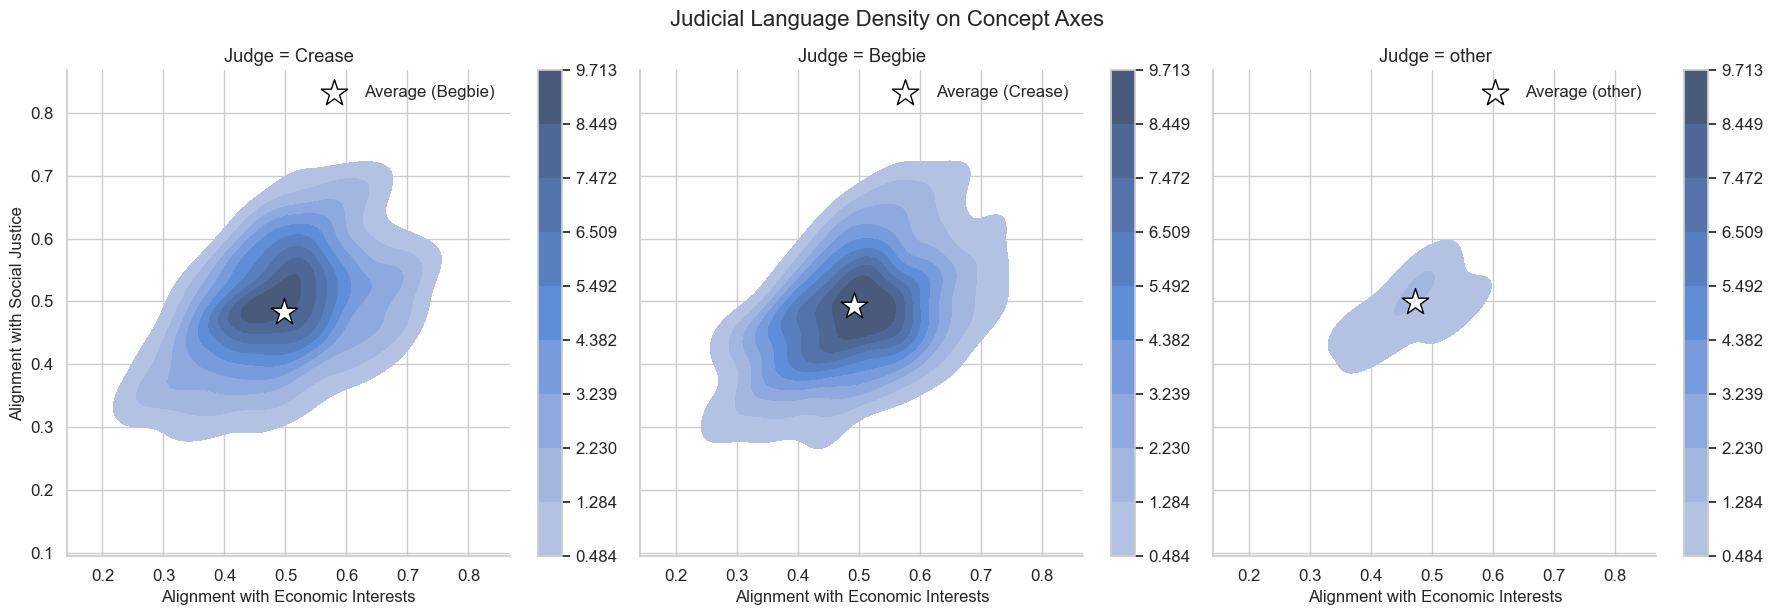

In [ ]:
results_df = pd.DataFrame(results)

aggregate_scores = results_df.groupby('Judge')[['Social_Score', 'Econ_Score']].mean()


g = sns.displot(
    data=results_df,
    x='Econ_Score',
    y='Social_Score',
    col='Judge',        
    kind='kde',         # Using Kernel Density Estimate 
    fill=True,          
    cbar=True,         
    height=6,           
    aspect=1           
)

for i, judge_name in enumerate(aggregate_scores.index):
    ax = g.axes.flat[i]
    avg_scores = aggregate_scores.loc[judge_name]
    
    ax.scatter(
        avg_scores['Econ_Score'],
        avg_scores['Social_Score'],
        s=400,
        marker='*',
        color='white',
        edgecolor='black',
        label=f'Average ({judge_name})' )
    ax.legend()

g.fig.suptitle('Judicial Language Density on Concept Axes', y=1.03, fontsize=16)
g.set_axis_labels('Alignment with Economic Interests', 'Alignment with Social Justice', fontsize=12)

plt.show()

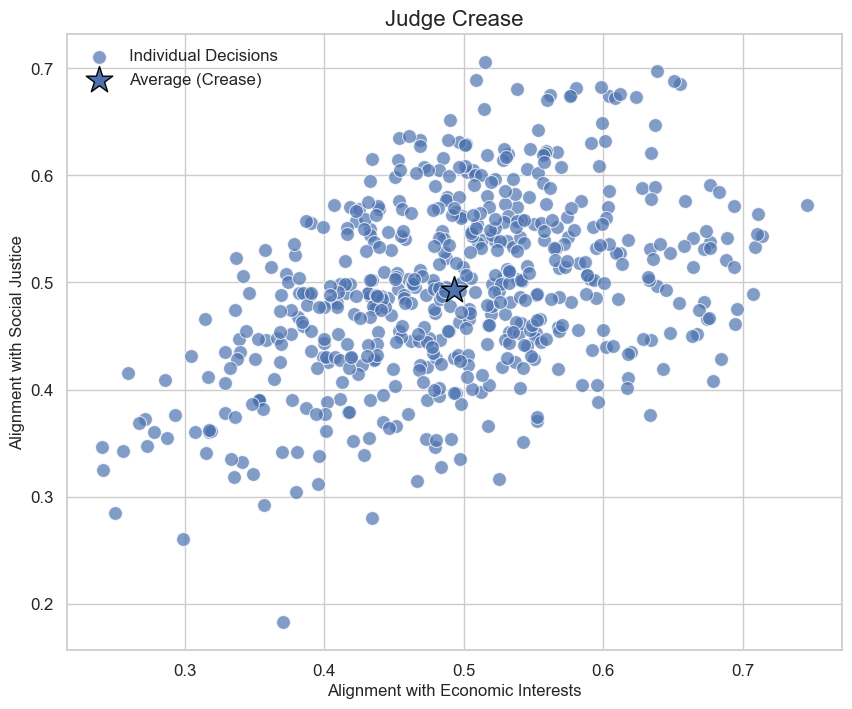

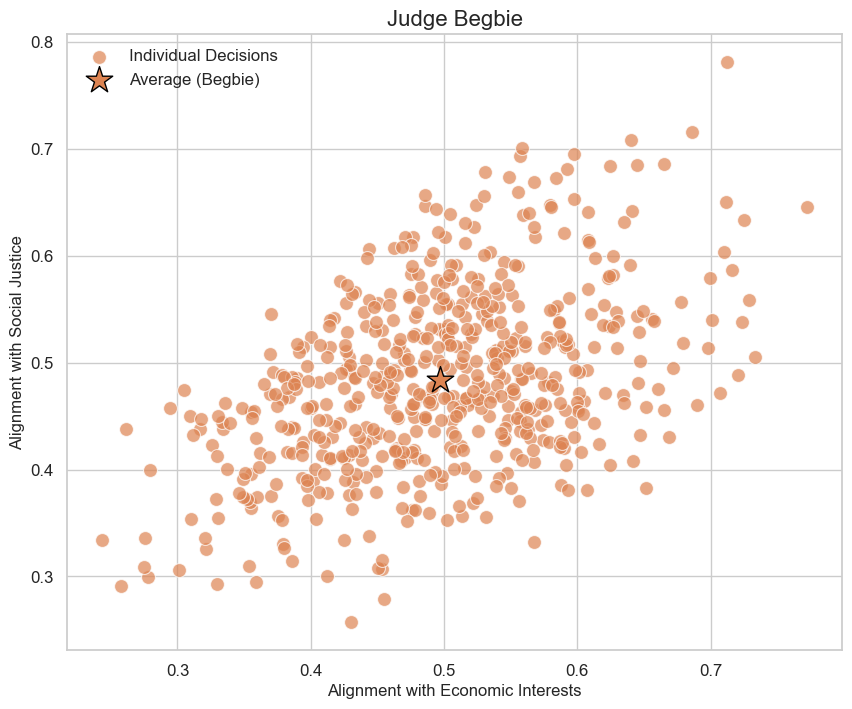

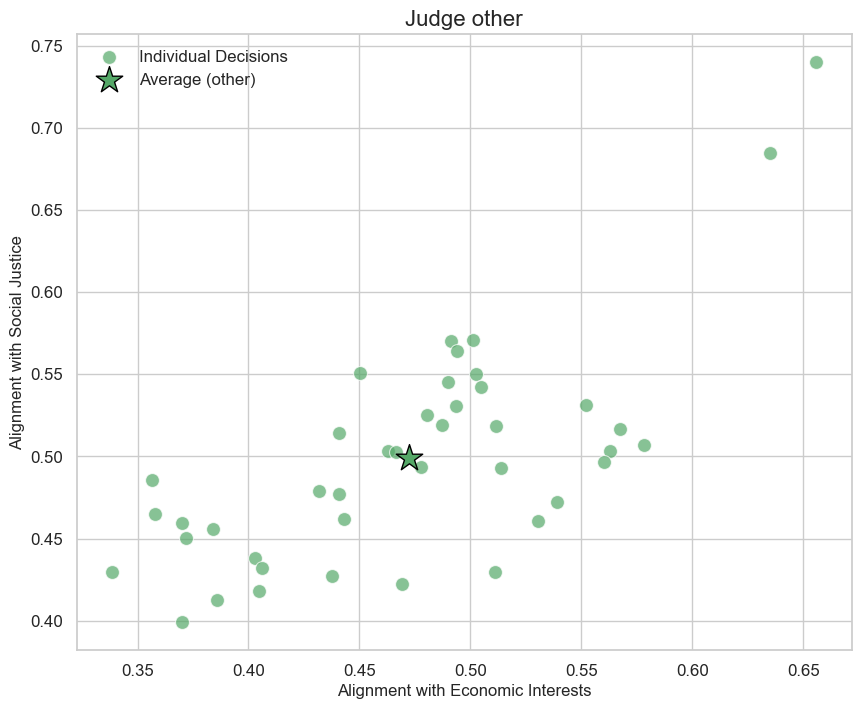

In [133]:
judges = results_df['Judge'].unique()

palette = sns.color_palette()

for i, judge_name in enumerate(judges):
    fig, ax = plt.subplots(figsize=(10, 8))
    judge_data = results_df[results_df['Judge'] == judge_name]
    sns.scatterplot(
        data=judge_data,
        x='Econ_Score',
        y='Social_Score',
        s=100,
        alpha=0.7,
        ax=ax,
        color=palette[i % len(palette)],
        label='Individual Decisions')
    
    avg_scores = aggregate_scores.loc[judge_name]
    ax.scatter(
        avg_scores['Econ_Score'], 
        avg_scores['Social_Score'], 
        s=400, 
        marker='*', 
        edgecolor='black', 
        label=f'Average ({judge_name})',
        c=[palette[i % len(palette)]])
    
    ax.set_title(f'Judge {judge_name}', fontsize=16)
    ax.set_xlabel('Alignment with Economic Interests', fontsize=12)
    ax.set_ylabel('Alignment with Social Justice', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    plt.show()

In [ ]:
from transformers import pipeline 
print("Loading sentiment analysis model...")
sentiment_pipeline = pipeline(
    'sentiment-analysis', 
    model='distilbert-base-uncased-finetuned-sst-2-english'
)

sentiments = []

for sentence in tqdm(results_df['Sentence']):
    result = sentiment_pipeline(sentence)[0]
    
    score = result['score']
    if result['label'] == 'NEGATIVE':
        score = -1
    else: score = 1
    sentiments.append(score)

results_df['Sentiment'] = sentiments

print("\nSentiment analysis complete.")
print(results_df.head())

Loading sentiment analysis model...


Device set to use cpu


  0%|          | 0/1184 [00:00<?, ?it/s]


Sentiment analysis complete.
    Judge                                           Sentence  Social_Score  \
0  Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.488737   
1  Crease                              5—Constitutionality—B      0.616317   
2  Crease                                      Act, 1867, ss      0.495978   
3  Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.554244   
4  Crease              On the return to a writ of certiorari      0.607982   

   Econ_Score  Sentiment  
0    0.390140         -1  
1    0.485073          1  
2    0.465056         -1  
3    0.550714          1  
4    0.471889         -1  


In [ ]:

print(results_df.groupby('Judge')[['Econ_Score', 'Social_Score', 'Sentiment']].count())

        Econ_Score  Social_Score  Sentiment
Judge                                      
Begbie         581           581        581
Crease         561           561        561
other           42            42         42


In [136]:
print(pd.crosstab(results_df['Judge'], results_df['Sentiment']))

Sentiment   -1    1
Judge              
Begbie     414  167
Crease     376  185
other       37    5


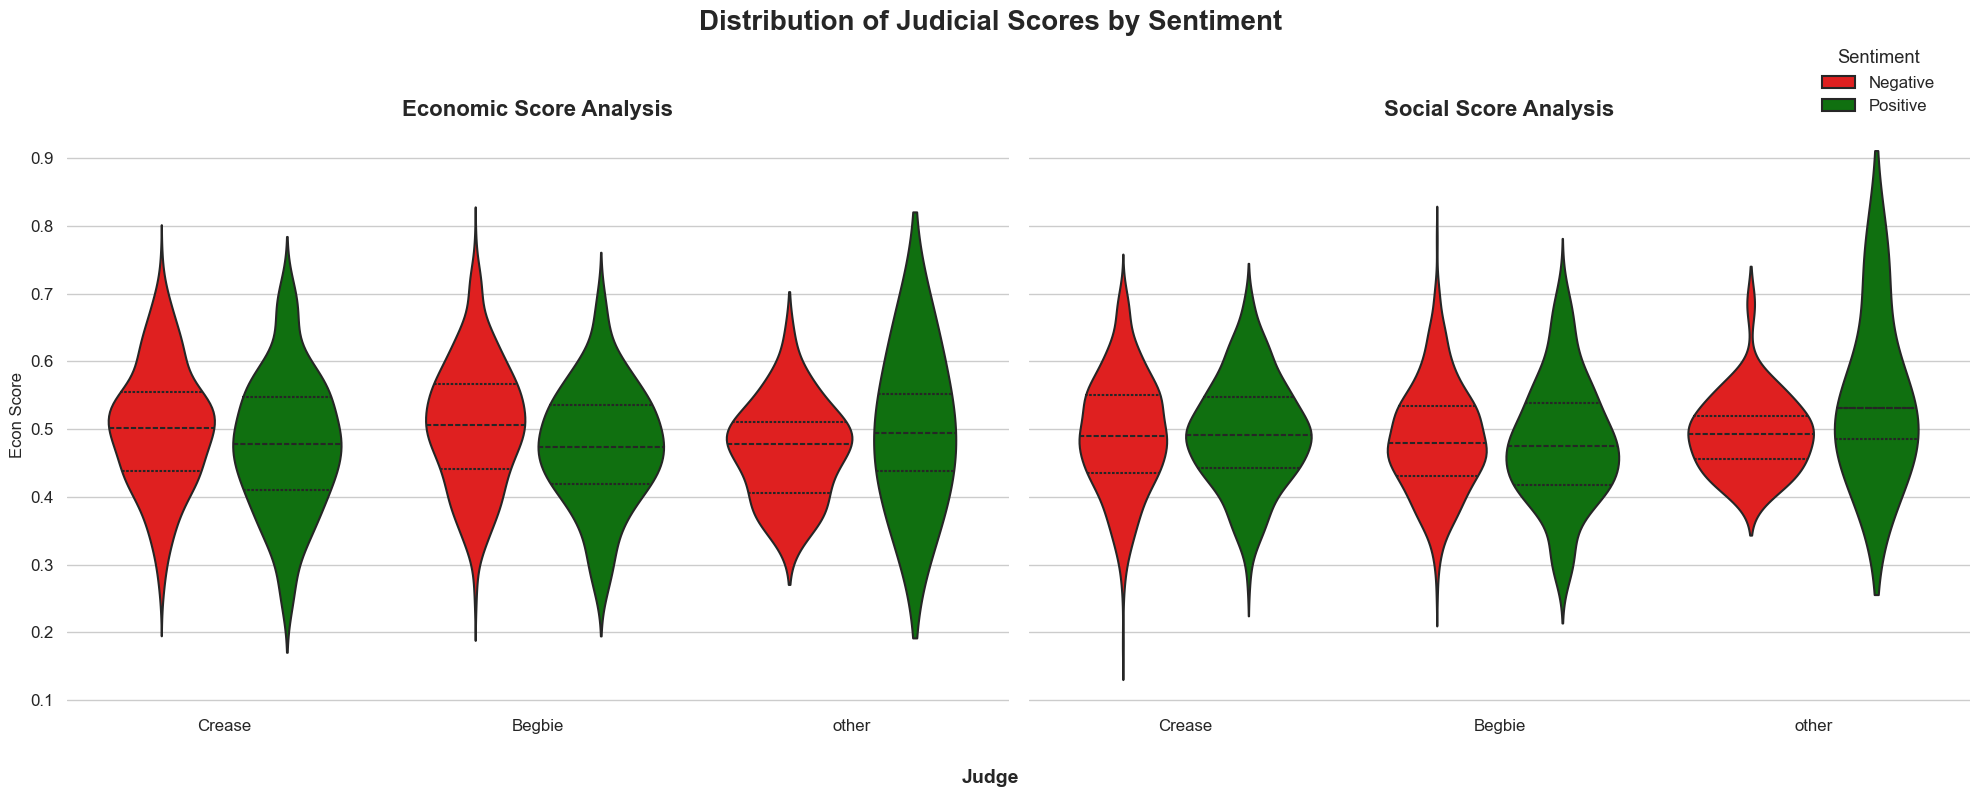

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_score_distribution(ax, data, score_col, title):
    sentiment_palette = {1: "green", -1: "red"} 
    
    sns.violinplot(
        data=data,
        x='Judge',
        y=score_col,
        hue='Sentiment',
        split=False,
        inner='quartile',
        palette=sentiment_palette,
        linewidth=1.5,
        ax=ax
    )
    
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_ylabel(f"{score_col.replace('_', ' ')}", fontsize=12)
    ax.set_xlabel(None) 
    ax.get_legend().remove() 
    
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Distribution of Judicial Scores by Sentiment', fontsize=20, weight='bold')


plot_score_distribution(
    ax=axes[0], 
    data=results_df, 
    score_col='Econ_Score', 
    title='Economic Score Analysis')
plot_score_distribution(
    ax=axes[1], 
    data=results_df, 
    score_col='Social_Score', 
    title='Social Score Analysis')

fig.text(0.5, 0.02, 'Judge', ha='center', va='center', fontsize=14, weight='bold')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Negative', 'Positive'], title='Sentiment', loc='upper right', bbox_to_anchor=(0.98, 0.95))
sns.despine(left=True, bottom=True)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Regressions

In [138]:
print(results_df)

       Judge                                           Sentence  Social_Score  \
0     Crease  14th & 15th July, Certiorari—“Chinese Regulati...      0.488737   
1     Crease                              5—Constitutionality—B      0.616317   
2     Crease                                      Act, 1867, ss      0.495978   
3     Crease      91, 92—“Aliens”—“Trade and Commerce”—Taxation      0.554244   
4     Crease              On the return to a writ of certiorari      0.607982   
...      ...                                                ...           ...   
1179   other  The Lieutenant-Governor in Council may, by any...      0.518521   
1180   other  The Lieutenant-Governor in Council may also ma...      0.485524   
1181   other  For the purpose of any proceeding taken under ...      0.464795   
1182   other  This Act shall not come into operation until o...      0.459314   
1183   other  This Act may be cited as the "Chinese Regulati...      0.564329   

      Econ_Score  Sentiment

We can test to what extent the effect of social score on sentiment depends on the Judge

In [143]:
results_df['is_crease'] = (results_df['Judge'] == 'Crease').astype(int)

In [144]:
import pandas as pd
import statsmodels.formula.api as smf
reg = "Sentiment ~ Social_Score * is_crease + Econ_Score * is_crease"
model = smf.ols(reg, data=results_df)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Sentiment   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.810
Date:                Wed, 30 Jul 2025   Prob (F-statistic):           2.62e-05
Time:                        21:22:49   Log-Likelihood:                -1564.1
No. Observations:                1184   AIC:                             3140.
Df Residuals:                    1178   BIC:                             3171.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [145]:
results_df['is_begbie'] = (results_df['Judge'] == 'Begbie').astype(int)

reg = "Sentiment ~ Social_Score * is_begbie + Econ_Score * is_begbie"
model = smf.ols(reg, data=results_df)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Sentiment   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.401
Date:                Wed, 30 Jul 2025   Prob (F-statistic):           6.42e-05
Time:                        21:24:19   Log-Likelihood:                -1565.1
No. Observations:                1184   AIC:                             3142.
Df Residuals:                    1178   BIC:                             3173.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

pretty terrible

# non-ml tf-idf

In [153]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Irene\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Irene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

someone please fix to use nltk libeary, nltk.download() doesnt work for me

In [ ]:
def preprocess_text(text_string):
    stop_words = {'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 
                  'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 
                  'below', 'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'could', 
                  "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 
                  'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 
                  'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 
                  'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', 
                  "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 
                  'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 
                  'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 
                  'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 
                  "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 
                  'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 
                  'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", 
                  "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 
                  'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', 
                  "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 
                  'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', 
                  "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 
                  'yourself', 'yourselves'}

    processed_text = text_string.lower()
    processed_text = re.sub(r'[^a-z\s]', '', processed_text)
    tokens = processed_text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)


df['processed_text'] = df['text'].apply(preprocess_text)

print(df)


                               filename       author    type  \
0               regina_v_wing_chong.txt       Crease    case   
1            wong_hoy_woon_v_duncan.txt       Crease    case   
2                  regina_v_mee_wah.txt       Begbie    case   
3                 regina_v_victoria.txt       Begbie    case   
4             quong_wing_v_the_king.txt  Fitzpatrick    case   
5  commission_on_chinese_imigration.txt       Powell  report   
6            chapleau_report_resume.txt     Chapleau  report   
7                 crease_commission.txt       Crease  report   
8                 begbie_commission.txt       Begbie  report   
9       chinese_regulation_act_1884.txt       Others     act   

                                                text  \
0  CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...   
1  CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n...   
2  BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...   
3  OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT...   
4  QUONG WING v

In [166]:
print(df)

                               filename       author    type  \
0               regina_v_wing_chong.txt       Crease    case   
1            wong_hoy_woon_v_duncan.txt       Crease    case   
2                  regina_v_mee_wah.txt       Begbie    case   
3                 regina_v_victoria.txt       Begbie    case   
4             quong_wing_v_the_king.txt  Fitzpatrick    case   
5  commission_on_chinese_imigration.txt       Powell  report   
6            chapleau_report_resume.txt     Chapleau  report   
7                 crease_commission.txt       Crease  report   
8                 begbie_commission.txt       Begbie  report   
9       chinese_regulation_act_1884.txt       Others     act   

                                                text  \
0  CREASE, J. 1885. REGINA v. WING CHONG. \r\n\r\...   
1  CREASE, J.\r\n\r\nWONG HOY WOON v. DUNCAN.\r\n...   
2  BRITISH COLUMBIA REPORTS.\r\n\r\nREGINA v. MEE...   
3  OF BRITISH COLUMBIA.\r\n\r\nREGINA r, CORPORAT...   
4  QUONG WING v

In [177]:
df['group'] = 'Other' 
df.loc[df['author'] == 'Crease', 'group'] = 'Crease'
df.loc[df['author'] == 'Begbie', 'group'] = 'Begbie'

three_docs_df = df.groupby('group')['processed_text'].apply(' '.join).reset_index()
three_docs_df = three_docs_df.set_index('group').reindex(['Crease', 'Begbie', 'Other']).reset_index()

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))

tfidf_matrix = vectorizer.fit_transform(three_docs_df['processed_text']).toarray()
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=feature_names, index=three_docs_df['group'])


for group_name in tfidf_df.index:
    print(f'author: {group_name}')
    top_words = tfidf_df.loc[group_name].sort_values(ascending=False).head(10)
    print(top_words)


author: Crease
chinese             0.420286
act                 0.260642
british             0.182450
white               0.149869
labor               0.140095
columbia            0.127063
dominion            0.123805
british columbia    0.123805
one                 0.123805
taxation            0.121664
Name: Crease, dtype: float64
author: Begbie
chinamen    0.272097
license     0.186489
may         0.179935
act         0.140437
licenses    0.133752
tax         0.131660
chinaman    0.131660
will        0.127271
revenue     0.124326
white       0.122882
Name: Begbie, dtype: float64
author: Other
shall             0.280915
chinese           0.277648
act               0.271115
may               0.192720
naturalized       0.185070
upon              0.166589
british           0.160056
legislation       0.146990
ac                0.143795
naturalization    0.143009
Name: Other, dtype: float64
